# Implement Baseline Strategy

In [23]:
# auto reload
%load_ext autoreload
%autoreload 2

# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import core_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def ma_strategy(inv_amt, prices_df, short_ma, long_ma, 
                transaction_costs = 0.001, # as a percent
                slippage = 0.0005 # as a percent
                ):
    # Returns a df with signals, positions, and returns
    df = prices_df.copy()
    df = df.drop(columns=['Dividends', "Capital Gains"], errors="ignore")  

    # calculate moving averages
    df["MA_short"] =  df["Close"].rolling(window = short_ma).mean()
    df["MA_long"] =  df["Close"].rolling(window = long_ma).mean()

    # generate signals
    df["signal"] = 0
    df.loc[df["MA_short"] > df["MA_long"], "signal"] = 1
        # 1 if MA short is above MA long, 0 otherwise

    # identify crossovers
    total_cost = transaction_costs + slippage
    df["position"] = df["signal"].diff()
    df["trade_cost"] = 0.0
    df.loc[df['position'] != 0, 'trade_cost'] = total_cost

    # calculate returns
    df['market_ret'] = df['Close'].pct_change()
    df['strategy_ret'] = df['market_ret'] * df['signal'].shift(1)
    df['strategy_ret_net'] = df['strategy_ret'] - df['trade_cost']
    
    # Market portfolio - buy at beginning, hold for the whole time
    df['market_ret_net'] = df['market_ret'].copy()
    df.loc[df.index[0], 'market_ret_net'] = df.loc[df.index[0], 'market_ret'] - total_cost

    # Calculate cumulative returns
    df['cumulative_market'] = (1 + df['market_ret_net']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_ret_net']).cumprod()
    
    # Portfolio value
    df['portfolio_value'] = inv_amt * df['cumulative_strategy']

    df = df.set_index("Date", inplace=False, drop=True, append=False)
   
    df.index = pd.to_datetime(df.index).tz_localize(None).normalize()

    
    return df

In [39]:
# running the strategy
# constants
investment_amount = 10000
test_data = pd.read_csv("../data/processed/training_data_70.csv")
short_ma = 20
long_ma = 50
result = ma_strategy(investment_amount, test_data, short_ma, long_ma)

In [42]:
result.tail()

,Open,High,Low,Close,Volume,Stock Splits,MA_short,MA_long,signal,position,trade_cost,market_ret,strategy_ret,strategy_ret_net,market_ret_net,cumulative_market,cumulative_strategy,portfolio_value
Date,,,,,,,,,,,,,,,,,,
2022-09-01,374.407182,378.114169,371.691250,377.771118,78740100,0.0,395.322708,381.919368,1,0.0,0.0,0.003138,0.003138,0.003138,0.003138,2.214503,1.720105,17201.048377
2022-09-02,381.449562,382.669345,371.967630,373.787781,99632100,0.0,394.311145,382.189626,1,0.0,0.0,-0.010544,-0.010544,-0.010544,-0.010544,2.191152,1.701968,17019.675116
2022-09-06,374.635914,375.579332,370.147495,372.377411,76637400,0.0,393.251935,382.202587,1,0.0,0.0,-0.003773,-0.003773,-0.003773,-0.003773,2.182885,1.695546,16955.456760
2022-09-07,372.062841,379.838970,371.843679,379.067078,70964200,0.0,392.605350,382.377738,1,0.0,0.0,0.017965,0.017965,0.017965,0.017965,2.222100,1.726006,17260.057286
2022-09-08,376.789585,382.002231,375.579312,381.544830,80821700,0.0,391.670975,382.753773,1,0.0,0.0,0.006536,0.006536,0.006536,0.006536,2.236624,1.737288,17372.876773


## Core Performance Metrics
To evaluate the basline strategy, we will perform the following tests.


### 1. Profit & Loss Metrics
Let's examine the returns and P&L of the strategy and market portfolios, considering transaction cost and slippage amounts as defined above.

Final portfolio value: 17372.876772805223 on 2022-09-08 00:00:00
Strategy returned 73.72876772805223% from 2015-01-02 00:00:00 to 2022-09-08 00:00:00
Market returned 123.66242209135079 from 2015-01-02 00:00:00 to 2022-09-08 00:00:00

Annualized across 7.6824 years: 
MA Strategy returned 7.4542% per year
Buy & Hold the market returned 11.0467% per year


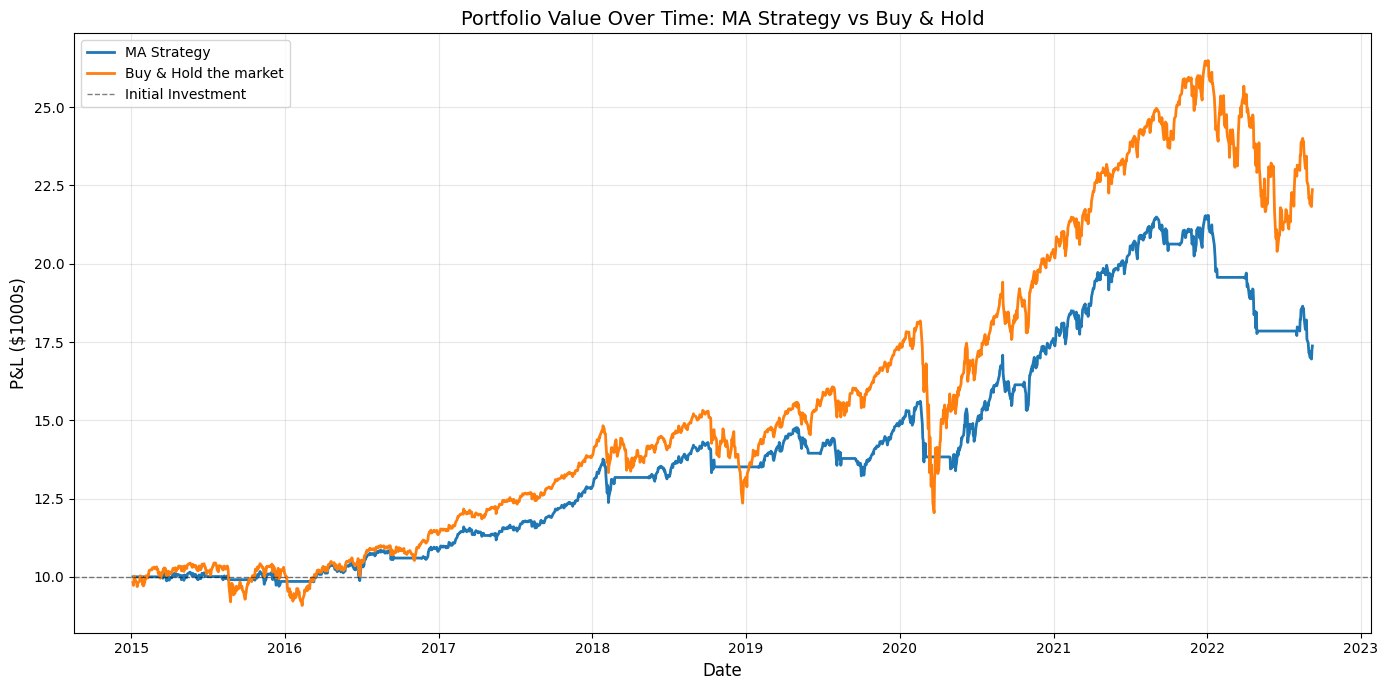

In [27]:
from core_metrics import pnl

graph_title = 'Portfolio Value Over Time: MA Strategy vs Buy & Hold'
strategy_name = "MA Strategy"
benchmark_name = "Buy & Hold the market"

result, strategy_annual_return, market_annual_return = pnl(result, investment_amount, strategy_name, benchmark_name, graph_title)

### 2. Performance Ratios

In [28]:
from core_metrics import performance_ratios

perf_ratios = performance_ratios(result)

print("WITHOUT transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe ratio']}")
print(f"Information Ratio: {perf_ratios['information ratio']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio']} \n")

print("WITH transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe with costs']}")
print(f"Information Ratios: {perf_ratios['information ratio with costs']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio with costs']}")


WITHOUT transaction costs...
Sharpe Ratio: 0.5471952097701563
Information Ratio: 8.847754882286592
Sortino Ratio: 9.751642893975802 

WITH transaction costs...
Sharpe Ratio: 0.4816603660491862
Information Ratios: 8.842502882315312
Sortino Ratio: 8.572224144380657


In [29]:
from core_metrics import risk_metrics

risks = risk_metrics(result)
print(f"Max Drawdown: {(100 * risks['max_drawdown']):.2f}%")
print(f"Average Drawdown: {(100 * risks['avg_drawdown']):.2f}%")
print(f"Max Drawdown Duration: {(risks['max_dd_duration']):.2f} days")
print(f"Average Drawdown Duration: {(risks['avg_dd_duration']):.2f} days")
print(f"Volatility: {(100 * risks['volatility']):.2f}%")

Max Drawdown: -21.30%
Average Drawdown: -3.42%
Max Drawdown Duration: 171.00 days
Average Drawdown Duration: 14.44 days
Volatility: 11.31%


### 4. Trade Statistics

In [30]:
from core_metrics import trade_statistics

trade_stats = trade_statistics(result)
print(f"Total Number of Trades: {trade_stats['num_trades']}")
print(f"Average Holding Periods: {trade_stats['avg_holding_period']}")
print(f"Win Rate: {trade_stats['win_rate']}")
print(f"Win-Loss Ratio: {trade_stats['win_loss_ratio']}")
print(f"Profit Factor (gross profit/gross loss): {trade_stats['profit_factor']}")


Total Number of Trades: 35
Average Holding Periods: 113.05882352941177
Win Rate: 0.6470588235294118
Win-Loss Ratio: inf
Profit Factor (gross profit/gross loss): 5.459718997147694


### 5. Strategy Beta to Benchmark

In [31]:
from core_metrics import find_alpha, calmar_ratio, find_beta

beta = find_beta(result, result.index[0], result.index[-1])
print(f'Beta: {beta}')
alpha = find_alpha(result, strategy_annual_return, market_annual_return)
print(f'Alpha: {alpha}')
calmar = calmar_ratio(strategy_annual_return, risks['max_drawdown'])
print(f'Calmar Ratio: {calmar:.2f}')

Beta: 0.380832167670367
Alpha: 0.02004543306113092
Calmar Ratio: 0.35


### 5. Consistency of Returns

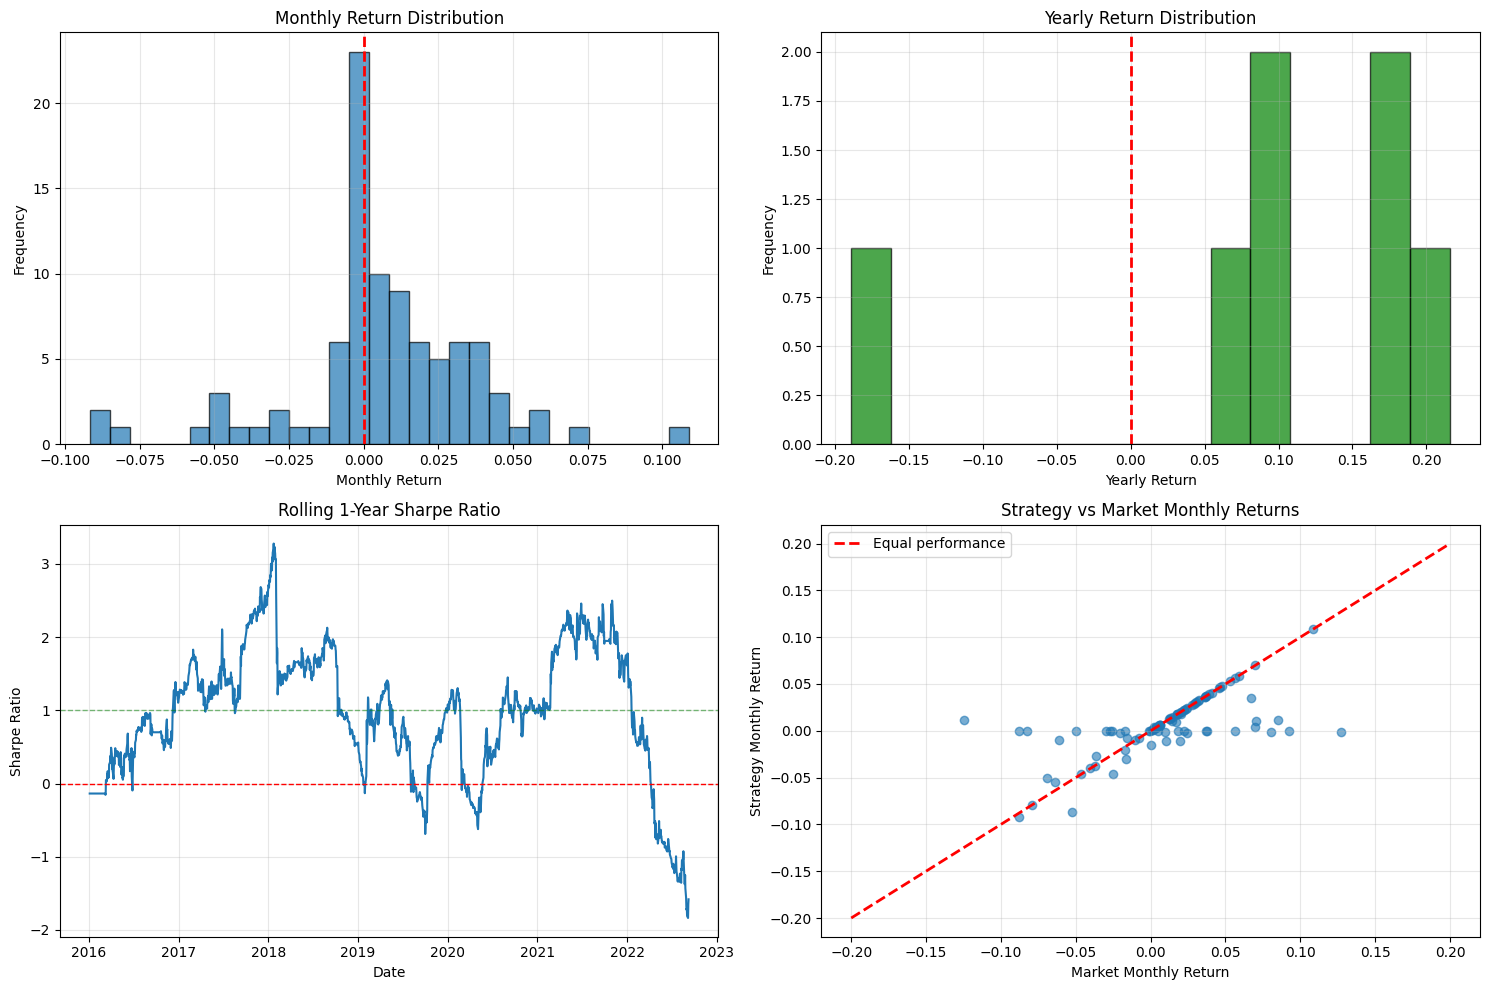

Percentage of Positive Months: 55.91%
Average Monthly Return: 0.65%
Median Monthly Return: 0.38%
Standard Deviation of Monthly Returns: 3.11%
Percentage of Positive Years: 75.00%
Average Yearly Return: 9.28%
Median Yearly Return: 9.90%


In [32]:
from core_metrics import consistency

window = 252 # trading days (for rolling sharpe)
consistency = consistency(result, window)

print(f"Percentage of Positive Months: {consistency['pct_positive_months']:.2%}")
print(f"Average Monthly Return: {consistency['avg_monthly_return']:.2%}")
print(f"Median Monthly Return: {consistency['median_monthly_return']:.2%}")
print(f"Standard Deviation of Monthly Returns: {consistency['std_monthly_return']:.2%}")

print(f"Percentage of Positive Years: {consistency['pct_positive_years']:.2%}")
print(f"Average Yearly Return: {consistency['avg_yearly_return']:.2%}")
print(f"Median Yearly Return: {consistency['median_yearly_return']:.2%}")


### 6. Sensitivity of Returns to Transaction Costs

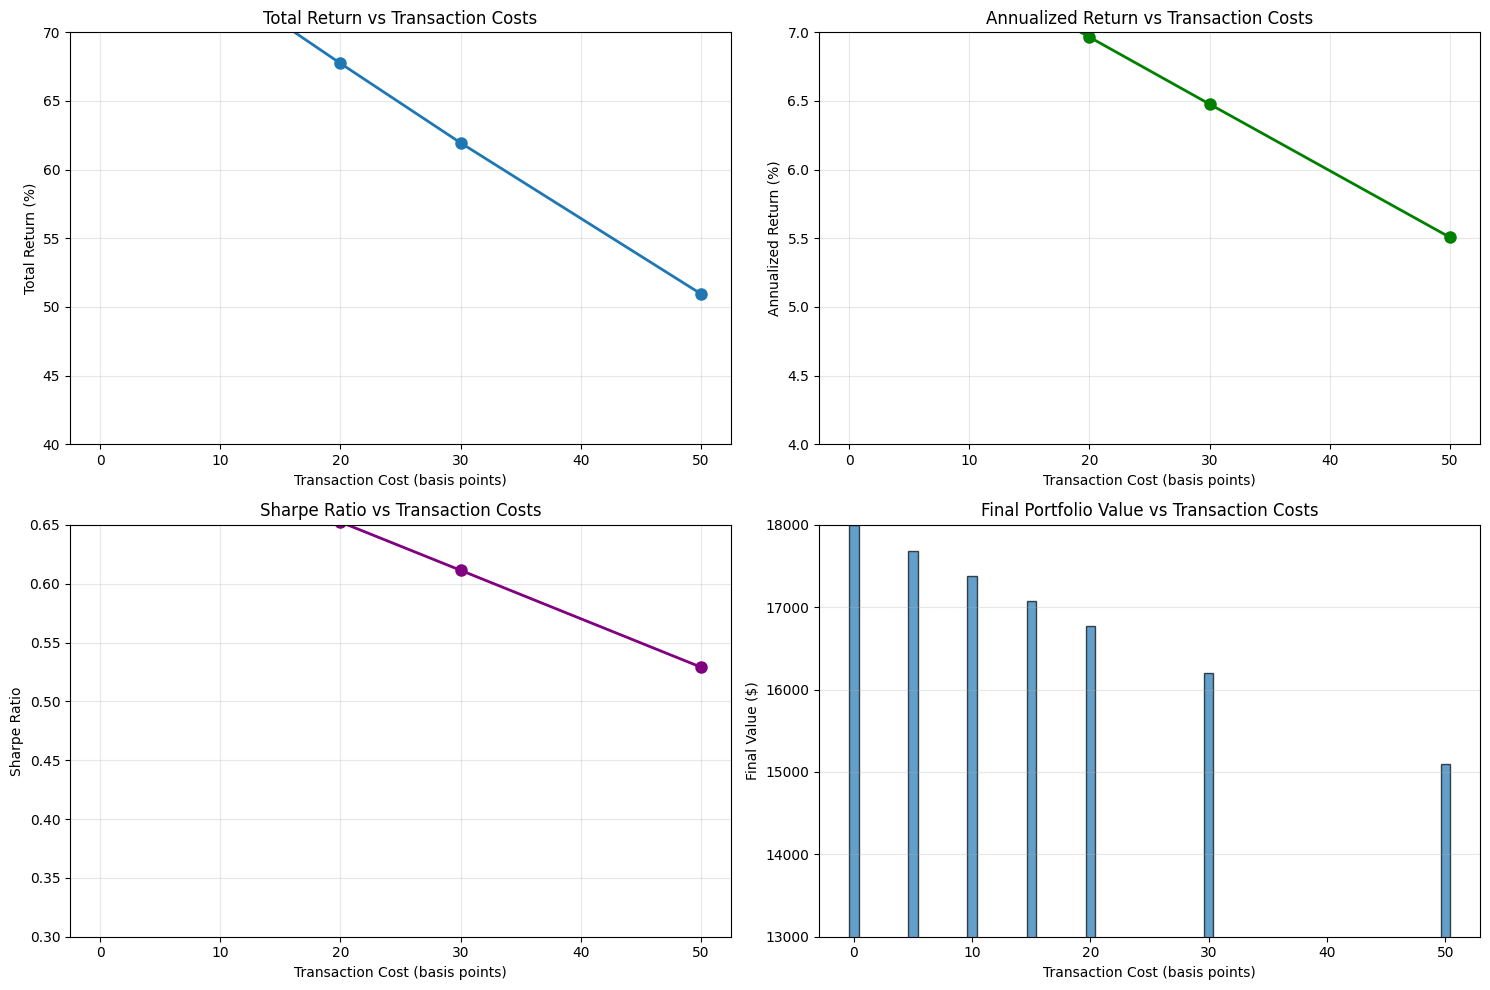

Transaction Cost Sensitivity Analysis
 cost_bps  cost_pct  total_return  annualized_return  sharpe_ratio  final_value
      0.0      0.00      0.799238           0.079454      0.733967 17992.384772
      5.0      0.05      0.768000           0.076996      0.713652 17679.995044
     10.0      0.10      0.737288           0.074542      0.693286 17372.876773
     15.0      0.15      0.707094           0.072093      0.672872 17070.943578
     20.0      0.20      0.677411           0.069648      0.652416 16774.110453
     30.0      0.30      0.619541           0.064771      0.611401 16195.411122
     50.0      0.50      0.509562           0.055068      0.529112 15095.620529


Strategy remains profitable at all tested cost levels


In [33]:
from core_metrics import sensitivity

prices_data = pd.read_csv("../data/processed/training_data_70.csv")
df = sensitivity(ma_strategy, investment_amount, prices_data, short_ma, long_ma)

